# Fermi Hubbard Model

__Author: Tanausú Hernández__

(-7.500000000000001e-08, 1.575e-06, -0.04997102104762898, 1.0499986200498872)

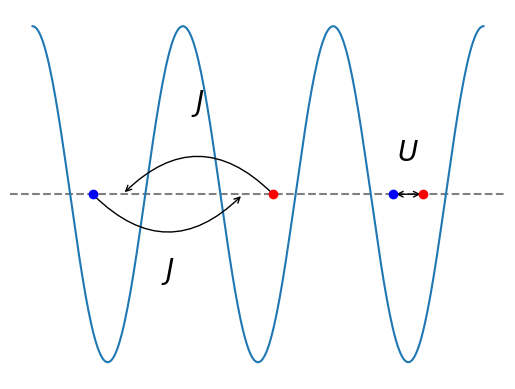

In [1]:
import numpy as np
import matplotlib.pyplot as plt

M = 3
a = 1e-6 # nm
x = np.linspace(0, M/2*a, 300)
y = np.sin(2*np.pi*(x/a+.25))**2

plt.axhline(.5, ls = 'dashed', color = 'grey')
plt.plot(x,y)
x = np.arange(3)*a/2+a/4
dx = a/20
xup = x+dx
xdown = x-dx
plt.scatter(xup[1:], [.5]*2,color = 'red', zorder = 5)
plt.scatter(xdown[::2], [.5]*2,color = 'blue', zorder = 5)

plt.annotate('', (xdown[1], .5), xytext = (xdown[0], .5), xycoords = 'data',
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3,rad=.5"))
plt.annotate('', (xup[0], .5), xytext = (xup[1], .5), xycoords = 'data',
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3,rad=.5"))
plt.text(sum(xdown[:2])/2, .25, '$J$', size = 20, horizontalalignment="center")
plt.text(sum(xup[:2])/2, .75, '$J$', size = 20, horizontalalignment="center")
plt.annotate('', (xdown[2], .5), xytext = (xup[2], .5), xycoords = 'data',
             arrowprops=dict(arrowstyle="<->"))
plt.text(x[2], .6, '$U$', size = 20, horizontalalignment="center")
plt.axis('off')

For fermions we must consider the field operators are now antisymmetric so that permutations of particles imply a change of sign. It also means we can't have two particles in the exact same state, but we can populate the lowest Bloch band with at most two particles with different internal state. The Fermi Hubbard then takes the form

$$H = -J\sum_j \sum_{\sigma} (\hat{c}_{j,\sigma}^\dagger\hat{c}_{j+1,\sigma} + \text{h.c.}) + U\sum_j\hat{n}_{j,\uparrow}\hat{n}_{j,\downarrow},$$

where $\hat{c}_{j,\sigma}$ is the annihilation operator at site $j$ for the internal states $\sigma = \uparrow, \downarrow$ and $\hat{n}_{j,\sigma}=\hat{c}_{j,\sigma}^\dagger\hat{c}_{j,\sigma}$ is the corresponding number operator. 


## Construction of Fock basis


We will keep using the Fock basis but with a few new constraints:
- We need to split the occupation numbers per site to accomodate the different internal states the fermion can take (up or down)
- Either one particle or no particle can occupy this states
- Creation/annihilation operators now obey anticommutator relations due to their antisymmetric nature

$$ \{\hat{c}_{j,\sigma}^\dagger, \hat{c}_{k,\sigma'}^\dagger\} = \{\hat{c}_{j,\sigma}, \hat{c}_{k,\sigma'}\} = 0,\\ \{\hat{c}_{j,\sigma}^\dagger, \hat{c}_{k,\sigma'}\} = \delta_{j,k}\delta_{\sigma,\sigma'} .$$

This last point is very important because it means we need to be careful about our definition of Fock states as the permutation of two annihilation operators of different quantum numbers now imply a global change of sign:

$$ \hat{c}_{j,\sigma} \hat{c}^\dagger_{k,\sigma'} = - \hat{c}_{j,\sigma} \hat{c}_{k,\sigma'}^\dagger;\ \forall j\ne k \lor \sigma \ne \sigma' $$

So for our definition of states to be consistent we need to set an order of creation operators in our Fock states, Hamiltonians and observables. For example, we can say we order the operators first by internal state, which we will simply call spin from now on, and then by lattice site. This is an arbitrary choice, but we can't change it midway or our calculations will be affected.

So for the sake of coherence between reader and lecturer let us fix this hierarchy for the operators read from left to right as:
1. Spin state: all spin downs first, all spin ups second.
2. Lattice site: first lattice site first, then the second and so on.

So a state with all sites and all states occupied will look like:

$$ \left|\Psi \right> = c_{1, \downarrow}^\dagger \ldots c_{M,\downarrow}^\dagger c_{1,\uparrow}^\dagger \ldots c_{M,\uparrow}^\dagger \left|\text{vac}\right>$$


You are already familiar with the idea of ordering to get a good algorithm and we now know that we need to define a vector of $2M$ possible single particle states (2 possible spin states per lattice site) with occupation numbers 0 or 1. Remember the order we have imposed for the creation operators. 

The procedure is exactly the same as for bosons, except that we need to add a few constraints since the logic is basically the same but occupation numbers are now binary instead of base $N$.

To speed things up we will use the following function which is an adaptation of the previous algorithm for bosons. Please have a look and compare them.

In [2]:
def basis_calc(N, M):
    basis = []
    holes = 2*M-N
    v = [1 for i in range(N)] + [0 for i in range(holes)]
    basis.append(tuple(v))
    k=N-1
    while sum(v[holes:]) < N:
        if v[k] > 0 and k < 2*M-1 and sum(v[k:]) < 2*M-k:
            N_left = N - sum(v[:k+1])
            v[k]   = 0
            v[k+1] = 1
            v[k+2:] = [1 for i in range(N_left)] + [0 for i in range(k+2+N_left, 2*M)]
            basis.append(tuple(v))
            k += 1+N_left
        else:
            k -= 1
            
    basis_dic = {key: value for value, key in enumerate(basis)}
    
    return basis, basis_dic

Now we need to see how the action of creation/annihilation operators from the particular observable or Hamiltonian applies to the construction of new states so that we include the proper coefficients.

We can also impose the rule that, since a $c_{j,\uparrow}^\dagger$ operator will commute with all $c_{k,\downarrow}^\dagger\ \forall k$, all permutations to accomodate an operator in our order will have the same global sign with respect to the operators of the opposite spin. In other words, we might ignore the opposite spin operators when it comes to permutation sign calculations.


$$ 
c_{1, \uparrow}^\dagger\left|\downarrow, \downarrow, \downarrow; 0, 0, 0\right> 
=  (-1)^3 c_{1,\downarrow}^\dagger c_{2,\downarrow}^\dagger c_{3,\downarrow}^\dagger c_{1,\uparrow}^\dagger \left|\text{vac}\right> 
=  -c_{1,\downarrow}^\dagger c_{2,\downarrow}^\dagger c_{3,\downarrow}^\dagger c_{1,\uparrow}^\dagger \left|\text{vac}\right>,\\
c_{2, \uparrow}^\dagger\left|\downarrow, \downarrow, \downarrow; 0, 0, 0\right> 
=  (-1)^3 c_{1,\downarrow}^\dagger c_{2,\downarrow}^\dagger c_{3,\downarrow}^\dagger c_{2,\uparrow}^\dagger \left|\text{vac}\right>,
=  -c_{1,\downarrow}^\dagger c_{2,\downarrow}^\dagger c_{3,\downarrow}^\dagger c_{2,\uparrow}^\dagger \left|\text{vac}\right>.
$$

This is just a convention we are setting up for convenience, but you can also include them in the calculation if you want.

So finally, the way to calculate the action of a annihilation operator on our Fock states will be:

$$
\hat{c}_{j,\sigma} \left|n_{1,\downarrow}, \ldots, n_{M,\downarrow}; n_{1,\uparrow}, \ldots, n_{M,\uparrow}\right> = (-1)^{\sum_{k=1}^{j-1} n_{l,\sigma}}\sqrt{n_{j,\sigma}}\left|\ldots, n_{j,\sigma}-1, \ldots \right>,
$$

which depending on the occupation number yields

$$
\left|\text{vac}\right>\text{ iif } n_{j,\sigma} = 0, \\
(-1)^{\sum_{k=1}^{j-1}n_{l,\sigma}} \left|\ldots, n'_{j,\sigma} = 0, \ldots \right>\text{ iif } n_{j,\sigma} = 1,
$$

since for fermions we can only have, at most, one particle in a state of specific quantum numbers.


Likewise, for the creation operator:
$$
\hat{c}^\dagger_{j, \sigma} \left|n_{1,\downarrow}, \ldots, n_{M,\downarrow}; n_{1,\uparrow}, \ldots, n_{M,\uparrow}\right> = (-1)^{\sum_{k=1}^{j-1} n_{l,\sigma}}\sqrt{n_{j,\sigma}+1}\left|\ldots, n_{j,\sigma}+1, \ldots \right>,
$$


which in turn yields


$$
(-1)^{\sum_{k=1}^{j-1}n_{l,\sigma}} \left|\ldots, n'_{j,\sigma} = 1, \ldots \right>\text{ iif } n_{j,\sigma} = 0, \\
\left|\text{vac}\right>\text{ iif } n_{j,\sigma} = 1.
$$

## Computation of Hamiltonian

While the Hamiltonian looks very similar to the Bose-Hubbard case, we now need to take into account the permutation sign due to the reordering of the creation operators and the fact that we can't add more than one particle per occupation number.

Luckily the interaction Hamiltonian 

$$ \hat{H}_{int} = U\sum_j \hat{n}_{j,\uparrow} \hat{n}_{j, \downarrow} .$$


is still diagonal and since we need two permutations per occupation operator due to $\hat{n}_{j, \sigma} = \hat{a}^\dagger_{j, \sigma}\hat{a}_{j, \sigma}$ then

$$
\hat{n}_{j, \sigma}\hat{a}^\dagger_{l, \sigma} = \hat{a}^\dagger_{j, \sigma}(-\delta_{l,j} - \hat{a}^\dagger_{l, \sigma} \hat{a}_{l, \sigma}) = \hat{a}_{l, \sigma}^\dagger \hat{n}_{j, \sigma};\ \forall l \ne j.
$$

This means we don't need to care about the permutation sign in the matrix calculation for the interaction Hamiltonian.

__Exercise:__

Write a function that depends on $U$ and a given basis which yields the interaction Hamiltonians as a ``scipy.sparse.csc_array`` object. To construct the Hamiltonian itself use a (```scipy.sparse.dia_array```)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dia_array.html] and use the ``.tocsc()`` method to transform the ``dia_array`` into a ``csc_array``. 

Calculate the interaction Hamiltonian for $U=1$ in matrix representation making use of the Fock basis function previously defined for the case $N=M=3$. Print the resulting matrix.

In [3]:
# Write your code here























__Example solution:__

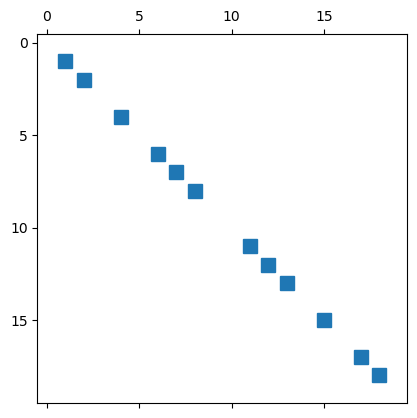

In [4]:
from scipy import sparse

def H_int(U, basis):
    A, T = basis
    M = len(A[0]) // 2
    N = sum(A[0])
    D = len(A)
    diag = []
    for i, v in enumerate(A):
        H_ii = 0
        for j in range(M):
            H_ii += v[j]*v[j+M]
        diag.append(U*H_ii)
    H_int = sparse.dia_array((diag, 0), (D,D))
    
    return H_int.tocsc()

N = M = 3
basis = basis_calc(N, M)
H = H_int(1, basis)

plt.spy(H)

Now we must tackle the tunnelling Hamiltonian

$$\hat{H}_{0} = -J \sum_j \sum_\sigma \left(\hat{a}_{j,\sigma}^\dagger \hat{a}_{j+1,\sigma} + \hat{a}_{j+1, \sigma}^\dagger \hat{a}_{j, \sigma}\right),$$ 

which is identical to the bosonic case in shape, expect for the addition of the spin quantum number. However, we need to be careful about the particularities of fermionic statistics (permutations, binary occupation numbers, double amount of possible states). 

Notice especially that the __occupation numbers are changed when we apply the annihilation operator__, so the number of permutations for the creation operator will be different!


For simplicity, let us look at one particular term of the tunnelling Hamiltonian applied to an arbitrary state where we only look at spin down states (we assume $n_{j,\sigma} = 1, n_{j+1,\sigma} = 0$ or it will project the state into the vaccuum) : 

$$ 
\hat{a}_{j+1, \downarrow}^\dagger \hat{a}_{j, \downarrow} \left|n_1, \ldots, n_j, \ldots, n_M\right>_\downarrow 
= \hat{a}_{j+1, \downarrow}^\dagger (-1)^{\sum_{k=1}^{j-1}n_{l,\downarrow}} \sqrt{1}\left|\ldots, n'_{j} = 0, \ldots \right>_\downarrow, \\ 
%\hat{a}_{j+1, \downarrow}^\dagger \hat{a}_{j, \downarrow} \left|n_1, \ldots, n_j, \ldots, n_M\right>_\downarrow 
= (-1)^{\sum_{k=1}^{j}n'_{l,\downarrow}} (-1)^{\sum_{k=1}^{j-1}n_{l,\downarrow}} \sqrt{1}\sqrt{0+1}\left|\ldots, n'_{j} = 0, n''_{j+1} = 1 \ldots \right>_\downarrow, \\
%\hat{a}_{j+1, \downarrow}^\dagger \hat{a}_{j, \downarrow} \left|n_1, \ldots, n_j, \ldots, n_M\right>_\downarrow 
= (-1)^{\sum_{k=1}^{j-1}n_{l,\downarrow}} (-1)^{\sum_{k=1}^{j-1}n_{l,\downarrow}} \left|n_1, \ldots, 0, 1, \ldots, n_M\right>_\downarrow, \\
%\hat{a}_{j+1, \downarrow}^\dagger \hat{a}_{j, \downarrow} \left|n_1, \ldots, n_j, \ldots, n_M\right>_\downarrow 
= \underbrace{\left((-1)^{\sum_{k=1}^{j-1}n_{l,\downarrow}}\right)^2}_{=1} \left|n_1, \ldots, 0, 1, \ldots, n_M\right>_\downarrow.
$$

So 

$$
\hat{a}_{j+1, \downarrow}^\dagger \hat{a}_{j, \downarrow} \left|n_1, \ldots, n_j, \ldots, n_M\right>_\downarrow \ne (-1)^{\sum_{k=1}^{j}n_{l,\downarrow}} (-1)^{\sum_{k=1}^{j-1}n_{l,\downarrow}} \left|n_1, \ldots, 0, 1, \ldots, n_M\right>_\downarrow = - \left|n_1, \ldots, 0, 1, \ldots, n_M\right>_\downarrow.\\
$$


__Exercise:__
    
Write a function that depends on $J$ and a given basis which yields the tunnelling Hamiltonians as a (``scipy.sparse.csc_array``)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_array.html] object.

Calculate the result for $N=M=3, J = 1$.


In [5]:
# Write your code here























__Example solution:__

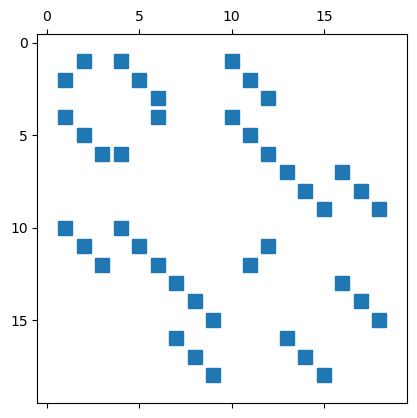

In [6]:
def H_0(J, basis):
    A, T = basis
    M = len(A[0]) // 2
    N = sum(A[0])
    D = len(A)
    data, row, col = [], [], []
    for i, v in enumerate(A):
        for j in range(M):
            k_range = [(j-1) % M, (j+1) % M]
            for k in k_range:
                for s in (0, M):
                    if v[s+k] > 0: 
                        u = list(v)
                        permutations = (-1) ** sum(v[s:s+k])
                        u[s+k] -= 1
                        if u[s+j] == 0:
                            permutations *= (-1) ** sum(u[s:s+j])
                            u[s+j] += 1
                            H_jk = -J * permutations * np.sqrt(u[j]) * np.sqrt(v[k])
                            r = T[tuple(u)]
                            data.append(H_jk)
                            row.append(r)
                            col.append(i)
    
    return sparse.csc_array((data, (row, col)), shape = (D, D))

N = M = 3
basis = basis_calc(N, M)
H = H_0(1, basis)

plt.spy(H)    

## Diagonalization and expectation values

The current matrices are mathematically  analogous to the ones in the Bose-Hubbard model (and any kind of Hermitian Hamiltonian), so we can use the same procedures as before.

__Example solution:__

In [7]:
N = 3
M = 3
basis = basis_calc(N, M)
H = H_int(.2, basis) + H_0(5, basis)
w, v = sparse.linalg.eigsh(H, k = 1, which = 'SA')
print(w[0], v[:, 0])

-9.867261881037793 [ 1.11022302e-16  1.14811589e-15  1.11022302e-15  3.33066907e-16
  1.73472348e-15  9.57567359e-16  1.27675648e-15 -7.05041743e-02
  1.21218510e-01 -5.64890365e-01  5.55111512e-16  5.55111512e-17
  3.88578059e-16 -7.05041743e-02  1.22849187e-01 -5.57392117e-01
 -7.14526230e-02  1.21218510e-01 -5.57392117e-01  0.00000000e+00]


In [8]:
def expectation_value(wf, A):
    return np.conj(wf).dot(A.dot(wf))

gs = v[:, 0]
expectation_value(gs, H)

-9.867261881037784

## Unitary time evolution

Another general method we can use for any Hamiltonian is the calculation of the [time evolution operator](https://ocw.mit.edu/courses/22-51-quantum-theory-of-radiation-interactions-fall-2012/485cf9e8ede00033f1c7d7b6eb6fecb2_MIT22_51F12_Ch5.pdf). A unitary time evolution operator ($\left|\psi(t)\right> = \hat{U}(t, 0) \left|\psi(t)\right>$) must fullfill the Schrodinger equation so that

$$
i\hbar\frac{\partial \hat{U}}{\partial t} = \hat{H}\hat{U}
.$$

If the Hamiltonian is time-independent this becomes a simple ODE with solution

$$
\hat{U}(t) = e^{-i\hat{H}t}
.$$

So for our case we just need to calculate the exponential of our Hamiltonian to obtain the evolution operator, but be aware this is _not_ the same as calculating the exponential of a function since we are working with matrices!

The formal definition of the exponential is 

$$\text{exp}(x) = \sum_{k=0}^\infty \frac{x^k}{k!},$$

so for the exponentiation of a non-diagonal matrix we need to calculate matrix products until convergence. We will use an specific function to calculate them, [`scipy.sparse.linalg.expm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.expm.html).

__Exercise:__

Define an unitary evolution operator function for parameters `H, t` that returns the exponential matrix of `-1j*H*t`. Calculate

$$
e^{-iHt} - \prod_{j=1}^{10} e^{-i H \frac{t}{10}} \mid t = 1
,$$

using the previously calculated `H`.

In [9]:
# Write your code here























__Example solution:__

In [10]:
def U(H, t):
    return sparse.linalg.expm(-1j*H*t)

t = 1
N_steps = 10
dt = t/N_steps
dU = U(H, dt)
U_product = dU
for n in range(N_steps-1):
    #U_product = U_product.dot(dU)
    U_product @= dU


diff = U(H, t) - U_product
delta = sum(abs(diff).data)
print(diff)
print(delta)

  (1, 1)	(1.3877787807814457e-16-1.3877787807814457e-16j)
  (2, 1)	(-2.220446049250313e-16-8.326672684688674e-17j)
  (3, 1)	(3.0531133177191805e-16+1.1102230246251565e-16j)
  (4, 1)	(1.1102230246251565e-16-2.7755575615628914e-17j)
  (5, 1)	(-1.1102230246251565e-16-1.1102230246251565e-16j)
  (6, 1)	(-5.551115123125783e-17+4.163336342344337e-16j)
  (10, 1)	(-1.1102230246251565e-16+8.326672684688674e-17j)
  (11, 1)	(4.440892098500626e-16+8.326672684688674e-17j)
  (12, 1)	(-6.938893903907228e-17+2.237793284010081e-16j)
  (1, 2)	(-6.106226635438361e-16-2.498001805406602e-16j)
  (2, 2)	(2.498001805406602e-16-3.3306690738754696e-16j)
  (3, 2)	(-5.551115123125783e-17-1.8041124150158794e-16j)
  (4, 2)	(-6.106226635438361e-16+7.355227538141662e-16j)
  (5, 2)	(-5.551115123125783e-17-8.049116928532385e-16j)
  (6, 2)	(2.0816681711721685e-16+1.5439038936193583e-16j)
  (10, 2)	(2.7755575615628914e-16-2.220446049250313e-16j)
  (11, 2)	(-1.6653345369377348e-16+3.0531133177191805e-16j)
  (12, 2)	(2.2204

This is an acceptable solution, but it turns out that numerically calculating $e^{M}\cdot \vec{v}$ is in general more efficient than calculating $e^{M}$ and then multiply by $\vec{v}$, where $M$ is a matrix and $\vec{v}$ a vector. For that, we have the [scipy.sparse.linalg.expm_multiply](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.expm_multiply.html) function. This function also allows us to more efficiently calculate the evolution at intermediate times based on the idea of splitting the evolution operator in small chunks of time as we have seen in the previous example. 

We will focus on the Schrodinger picture so that the evolution is represented in the state only and we can use this function for the evolution of expectation values.

__Exercise:__

Define the `evolve` function that depends on parameters `A, wf, H, t_f, N_steps` where `A` is an observable in matrix form, `wf` is the initial state as an 1D `np.array`, `H` is the Hamiltonian in matrix form, `t_f` is the final time of the evolution and `N_steps` is the number of time points for the evolution. 

- Use the `expm_multiply` function to calculate $e^{-i\hat{H}t}\cdot \text{w.f.}$
- The function must return a time array using `np.linspace` and the expectation value of the observable in N_steps time points from $t_0=0$ to $t_f$

Test that the energy of the ground state (or any eigenstate) doesn't evolve in time.

In [11]:
# Write your code here























__Example solution:__

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ] [-9.86726188+0.00000000e+00j -9.86726188-6.83481050e-16j
 -9.86726188+1.87350135e-16j -9.86726188+5.20417043e-18j
 -9.86726188-2.08166817e-17j -9.86726188-2.11636264e-16j
 -9.86726188+2.25514052e-16j -9.86726188-1.02348685e-16j
 -9.86726188+2.08166817e-17j -9.86726188+6.45317133e-16j]


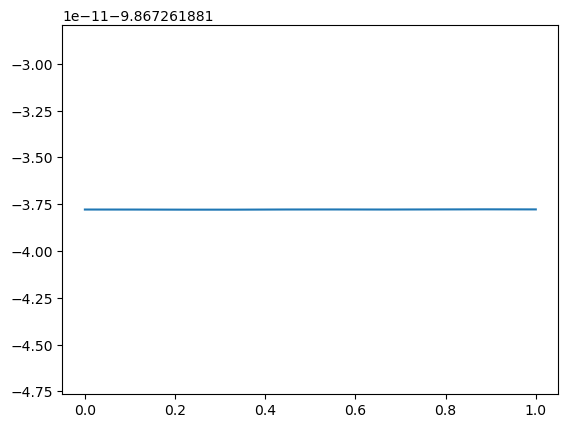

In [12]:
def evolve(A, wf, H, t_f, N_steps):
    t = np.linspace(0, t_f, N_steps)
    wf_array = sparse.linalg.expm_multiply(-1j*H, wf, start = 0, stop = t_f, num = N_steps)
    result = []
    for i in range(N_steps):
        result.append(expectation_value(wf_array[i, :], A))
    return t, np.array(result)


t, E = evolve(H, gs, H, 1, 10)
print(t, E)

plt.plot(t, E.real)

## Spin Operators

Since the particles can now occupy two different spin states per lattice site, it makes sense to define local spin operators for three different spin projections in the Bloch sphere:

$$
\hat{S}_{j}^{x} = \frac{1}{2}\left(\hat{S}_{j}^{+} + \hat{S}_{j}^{-}\right)
 = \frac{1}{2}\left(\hat{a}_{j,\uparrow}^\dagger \hat{a}_{j,\downarrow} + \hat{a}_{j,\downarrow}^\dagger \hat{a}_{j,\uparrow}\right)
,\\
\hat{S}_{j}^{y} = \frac{1}{2i}\left(\hat{S}_{j}^{+} - \hat{S}_{j}^{-}\right)
 = \frac{1}{2i}\left(\hat{a}_{j,\uparrow}^\dagger \hat{a}_{j,\downarrow} - \hat{a}_{j,\downarrow}^\dagger \hat{a}_{j,\uparrow}\right)
,\\
\hat{S}_{j}^{z} = \frac{1}{2}\left(\hat{n}_{j,\uparrow} - \hat{n}_{j,\downarrow}\right)
 = \frac{1}{2}\left(\hat{a}_{j,\uparrow}^\dagger \hat{a}_{j,\uparrow} - \hat{a}_{j,\downarrow}^\dagger \hat{a}_{j,\downarrow}\right)
.
$$

This in turn allows us to define global spin operators 

$$
\hat{S}^{x} = \sum_j \hat{S}_{j}^{x}
,\\
\hat{S}^{y} = \sum_j \hat{S}_{j}^{y}
,\\
\hat{S}^{z} = \sum_j \hat{S}_{j}^{z}
.
$$

This is very useful for checking the validity of projections onto spin model Hamiltonians or measurement of spin squeezing parameter.

__Exercise:__

Create a function that returns the local spin operators for a given basis. It should return 3 lists $(\hat{S}^x, \hat{S}^y, \hat{S}^z)$ of $M$ local operators.  

In [13]:
# Write your code here























__Example solution:__

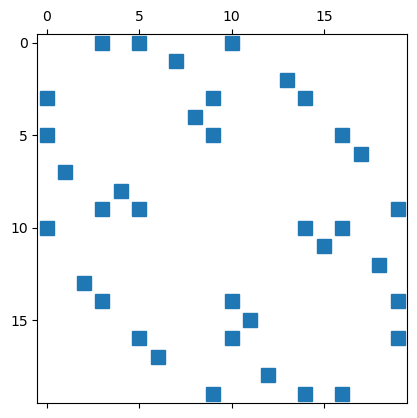

In [14]:
def S_calc(basis):
    A, T = basis
    D = len(A)
    M = len(A[0]) // 2
    Sx = []
    Sy = []
    Sz = []
    
    for j in range(M):
        Sp = []   # a_dagger_up * a_down
        Sm = []   # a_dagger_down * a_up
        Nu = []   # a_dagger_up * a_up
        Nd = []   # a_dagger_down * a_down
        for k, v in enumerate(A):
            if v[j] > 0:
                u = list(v)
                u[j] -= 1
                permutations = (-1) ** sum(v[:j])
                Nu.append([1, k, k])
                if u[j + M] == 0:
                    permutations *= (-1) ** sum(v[M:j + M])
                    u[j + M] += 1
                    r = T[tuple(u)]
                    Sm.append([permutations, r, k])
                    
            
            if v[j + M] > 0:
                u = list(v)
                u[j + M] -= 1
                permutations = (-1) ** sum(v[M:j + M])
                Nd.append([1, k, k])
                if u[j] == 0:
                    permutations *= (-1) ** sum(v[:j])
                    u[j] += 1
                    r = T[tuple(u)]
                    Sp.append([permutations, r, k])
                    
        Sp = np.array(Sp)
        Sm = np.array(Sm)
        Nu = np.array(Nu)
        Nd = np.array(Nd)
        
        Sp = sparse.csc_matrix((Sp[:,0], (Sp[:,1], Sp[:,2])), shape=(D, D), dtype=np.complex128)
        Sm = sparse.csc_matrix((Sm[:,0], (Sm[:,1], Sm[:,2])), shape=(D, D), dtype=np.complex128)
        Nu = sparse.csc_matrix((Nu[:,0], (Nu[:,1], Nu[:,2])), shape=(D, D), dtype=np.complex128)
        Nd = sparse.csc_matrix((Nd[:,0], (Nd[:,1], Nd[:,2])), shape=(D, D), dtype=np.complex128)

        Sx_j = .5*(Sp+Sm)
        Sy_j = -.5j*(Sp-Sm)
        Sz_j = .5*(Nu-Nd)
 
        Sx.append(Sx_j)
        Sy.append(Sy_j)
        Sz.append(Sz_j)

    return Sx, Sy, Sz


Sx, Sy, Sz = S_calc(basis)

plt.spy(sum(Sx))

__Exercise:__

Calculate the time evolution of the collective pin operator projectors for an arbitrary mixture of eigenstates until $t = 10, N_\text{steps} = 100$ and try to get some dynamics. Plot them in the same figure using [`plt.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html).

- To obtain the collective spin operator for each projection (x, y, z) you can use the `sum` function to sum the elements of an iterator.
- If you want to add a legend, use the argument `label` on each `plt.plot` call and use the `plt.legend()` function at the end of your script.

In [15]:
# Write your code here























__Example solution:__

In [16]:
w, v = sparse.linalg.eigsh(H, k = 5, which = 'SA')

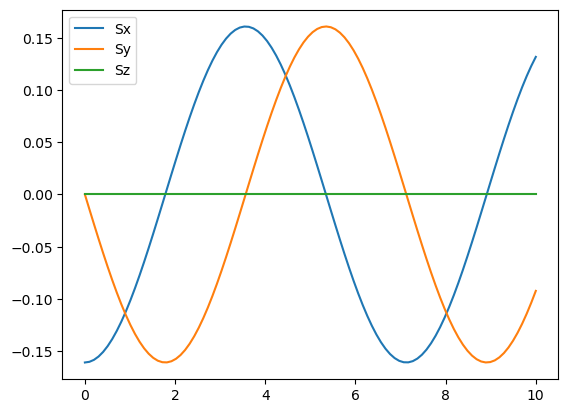

In [17]:
wf = v[:, 0] + v[:, 4]
wf /= sum(abs(wf)**2)

Sx, Sy, Sz = S_calc(basis)
Sx = sum(Sx)
Sy = sum(Sy)
Sz = sum(Sz)

t, Sx_t = evolve(Sx, wf, H, 10, 100)
plt.plot(t, Sx_t.real, label = 'Sx')
t, Sy_t = evolve(Sy, wf, H, 10, 100)
plt.plot(t, Sy_t.real, label = 'Sy')
t, Sz_t = evolve(Sz, wf, H, 10, 100)
plt.plot(t, Sz_t.real, label = 'Sz')
plt.legend()

## Heisenberg Model

Under certain conditions, the Fermi-Hubbard model may simulate dynamics of Hamiltonians initially written for magnetic systems due to the interactions between particles of different spin. Such is the Heisenberg model, which characterizes the interaction between dipoles in a quantum system by the Hamiltonian

$$ 
\hat{H} = -\sum_j \left(J_x\hat{S}_j^x\hat{S}_{j+1}^x +J_y\hat{S}_j^y\hat{S}_{j+1}^y +J_z\hat{S}_j^z\hat{S}_{j+1}^z + h \hat{S}_j^z\right)
, 
$$

where h is the external magnetic field strength and $J_x, J_y, J_z$ are coupling constants to each type of spin exchange term. If all of them are equal we refer to it as the XXX model, two of them as the XXZ model and if all of them are different we designate it as the XYZ model. The XXX model can be solved analitically using the Bethe ansatz.

__Exercise:__

Show that the dynamics of $\left<S^z\right>$ given an arbitrary state are the same for the Fermi Hubbard model and the Heisenberg XXX model 

$$ 
\hat{H} = -\frac{J^2}{4U}\sum_j \left(\hat{S}_j^x\hat{S}_{j+1}^x +\hat{S}_j^y\hat{S}_{j+1}^y +\hat{S}_j^z\hat{S}_{j+1}^z\right)
, 
$$

when $U \gg J$.

In [18]:
# Write your code here























__Example solution:__

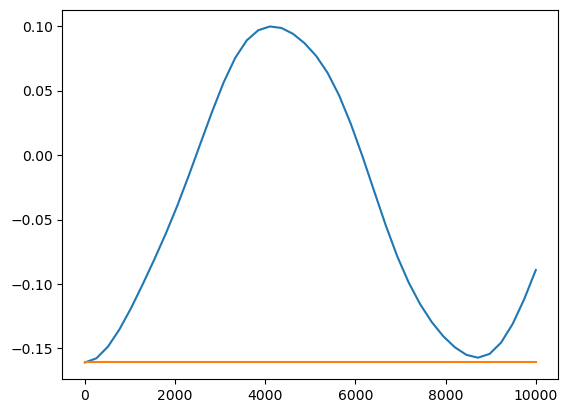

In [25]:
Sx, Sy, Sz = S_calc(basis)

U = 1
J = 1e-3*U

J_SE = J**2/4/U
t_f = 1e4#1/J_SE
N_steps = 40

'''
wf = np.zeros(len(basis[0]))
#wf[0] = 1

for v, i in basis[1].items():
    antiferr = []
    for j in range(M):
        neigh = (j+1) % M
        single_occ = v[j] + v[j+M] == 1
        antipar = v[j] != v[neigh]
        antiferr.append(antipar and single_occ)
    if all(antiferr):
        wf[i] = 1
       
#wf[:25] = 0
wf /= sum(abs(wf)**2)

print(wf)
'''

H_FH  = H_int(U, basis) + H_0(J, basis)
H_XXX = -J_SE*sum([Sx[i]*Sx[(i+1)%M] + Sy[i]*Sy[(i+1)%M] + Sz[i]*Sz[(i+1)%M] for i in range(M)])


t, Sz_FH = evolve(sum(Sx), wf, H_FH, t_f, N_steps)
t, Sz_XXX = evolve(sum(Sx), wf, H_XXX, t_f, N_steps)

plt.plot(t, Sz_FH.real)
plt.plot(t, Sz_XXX.real)